In [1]:
%matplotlib inline
import itertools
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import scipy
import scipy.io
import warnings
from scipy import signal      

warnings.filterwarnings("ignore")

In [6]:
class SIMPLe():
    
    def __init__(self):
        
        self.rec_freq=100
        self.weigth_time=2
        self.index=0
        
    def load(self, path='/home/oem/Desktop/KernelizedDynamicalSystems/robInfLib-matlab/2Dletters/O.mat'):
        
        X_demo= scipy.io.loadmat(path)
        self.traj=np.zeros([2,200])
        for j in range(0,200):
            self.traj[0,j]=(X_demo['demos'][0,0][0][0][0][0][j]-X_demo['demos'][0,0][0][0][0][0][-1])/10
            self.traj[1,j]=(X_demo['demos'][0,0][0][0][0][1][j]-X_demo['demos'][0,0][0][0][0][1][-1])/10
    def plot_traj(self):
        plt.scatter(self.traj[0,:],self.traj[1,:], color=[1,0,0])
        plt.show()    
    def execute(self):
        
        time_weight=self.rec_freq*self.weigth_time
        traj_error = np.linalg.norm(self.traj.T - np.array(self.cart_pos), axis=1)
         
        if self.index is not(None):    
            index_error= np.abs(np.arange(self.traj.shape[1])-self.index)/time_weight
            traj_error_total=traj_error+index_error
        else:
            traj_error_total=traj_error
        
        min_traj_error=np.min(traj_error)
        
        if np.min(min_traj_error) > 0.1: 
            beta= np.exp(-(min_traj_error-0.1)/0.1)
        else:
            beta=1
            
        i_belief = np.min([int(np.argmin(traj_error_total))+1, self.traj.shape[1]-1])

        attractor_pos = np.array(self.cart_pos)+ np.clip(np.array([self.traj[0][i_belief], self.traj[1][i_belief]])-np.array(self.cart_pos),-0.1,0.1)
        
        
        return  attractor_pos, i_belief, beta
    
    def rollout(self, ind, x, steps):
        
        if ind is not(None):
            self.index=ind
        else:
            self.index=None
        self.cart_pos=np.array([x[0],x[1]]).reshape(1,-1)
        self.traj_rollout=np.zeros((2,steps))
        self.traj_rollout[:,0]=x
        
        for i in range(steps-1):
            [attractor_pos, i_belief, beta]=self.execute()
            #self.index=ind
            if  ind is None:
                self.index=None
            else:
                self.index=belief         
            self.cart_pos=attractor_pos
            self.traj_rollout[:,i+1]= self.cart_pos
    
    def plot_stream(self,i=None):
        self.index=i
        x=np.linspace(np.min(self.traj[0,:])-0.2, np.max(self.traj[0,:])+0.2, 300)
        y=np.linspace(np.min(self.traj[1,:])-0.2, np.max(self.traj[1,:])+0.2, 300)
        u=np.ones((len(x),len(y)))
        v=np.ones((len(x),len(y)))
        BETA=np.ones((len(x),len(y)))
        XX, YY = np.meshgrid(x, y)
        for i in range(len(y)):
            for j in range(len(x)):
                self.cart_pos=np.array([XX[i,j],YY[i, j]]).reshape(1,-1)

                [attractor, i_belief, beta]= self.execute()

                u[i,j]=np.clip(attractor[0][0]-self.cart_pos[0][0],-0.1,0.1)
                v[i,j]=np.clip(attractor[0][1]-self.cart_pos[0][1],-0.1,0.1)
                BETA[i,j]=beta
                
                
        plt.scatter(self.traj[0,:],self.traj[1,:], color=[1,0,0])
        if self.index is not(None):
            plt.scatter(self.traj[0,self.index],self.traj[1,self.index], marker="*", color=[0,1,0], linewidths=2)
        domain = np.identity(3)
        u=scipy.signal.medfilt2d(u,kernel_size=11)
        v=scipy.signal.medfilt2d(v,kernel_size=11)
        plt.streamplot(XX, YY, u, v, density = 2, color=[0,0,0])
        plt.show()
        
        
SIMPLe=SIMPLe()

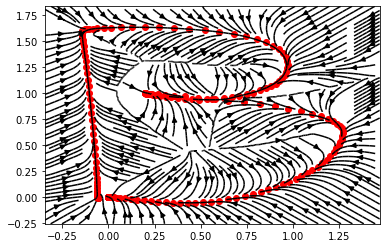

In [4]:
SIMPLe.load(path='/home/oem/Desktop/KernelizedDynamicalSystems/robInfLib-matlab/2Dletters/B.mat')
# SIMPLe.plot_stream(10)
# SIMPLe.plot_stream(i=88)
# SIMPLe.plot_stream(i=100)
# SIMPLe.plot_stream(i=107)
# SIMPLe.plot_stream(i=115)
# SIMPLe.plot_stream(i=199)
SIMPLe.plot_stream()

In [9]:
# SIMPLe=SIMPLe()
SIMPLe.load(path='/home/oem/Desktop/KernelizedDynamicalSystems/robInfLib-matlab/2Dletters/B.mat')
ind=None
SIMPLe.rollout(ind, SIMPLe.traj[:,0], 200)

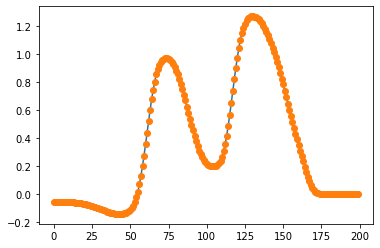

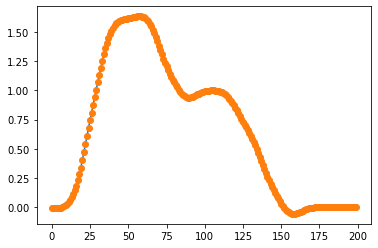

In [10]:
plt.plot(SIMPLe.traj[0,:])
plt.plot(SIMPLe.traj_rollout[0,:], 'o')
plt.show()
plt.plot(SIMPLe.traj[1,:])
plt.plot(SIMPLe.traj_rollout[1,:], 'o')

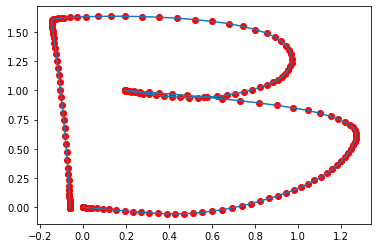

In [11]:
plt.plot(SIMPLe.traj[0,:],SIMPLe.traj[1,:],'o', color=[1,0,0])
plt.plot(SIMPLe.traj_rollout[0,:],SIMPLe.traj_rollout[1,:])
plt.show()